In [1]:
import gammapy
print(gammapy.__version__)

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import DataStore, Observation
from gammapy.datasets import MapDataset
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.makers import MapDatasetMaker
from gammapy.makers.utils import make_edisp_map, make_edisp_kernel_map
from gammapy.irf import EnergyDispersion2D
from utils import EdispInv

from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    TemplateSpatialModel,
    ExpDecayTemporalModel,
    LightCurveTemplateTemporalModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    LogParabolaSpectralModel,
    DatasetModels
)

0.20.1


## Create a MapDatset

In [2]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
obs_id = [23523] # just one observation 
obs1 = data_store.get_observations(obs_id)[0]

In [3]:
crab_pos = SkyCoord(184.557, -5.784, unit='deg', frame='galactic') 
obs_pos=obs1.pointing_radec
ebins = np.geomspace(0.5,100,100) # a fine binning in true energy
energy_axis = MapAxis.from_edges(
    ebins, unit="TeV", name="energy", interp="log"  
)
energy_axis_true = MapAxis.from_edges(
    ebins, unit="TeV", name="energy_true", interp="log"  
)
migra_axis = MapAxis.from_bounds(
    0.2, 5, nbin=160, node_type="edges", name="migra"
)
geom = WcsGeom.create(
    skydir=obs_pos,
    binsz=0.02,
    width=(3.5, 3.5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapDatasetMaker(selection=['edisp', 'exposure'])
reference = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, migra_axis=migra_axis)

dataset = maker.run(reference, obs1)

CPU times: user 2.24 s, sys: 594 ms, total: 2.83 s
Wall time: 2.88 s


## EdispKernel Generation
Check how Gammapy generates the EdispKernel from the Edisp2D

In [5]:
kernel_from_ds = dataset.edisp.get_edisp_kernel(energy_axis)
kernel_from_edisp2d = obs1.edisp.to_edisp_kernel(0.1*u.deg,
                                                 energy_true=energy_axis.edges, 
                                                 energy = energy_axis.edges)

In [6]:
# a direct computation of the Kernel using `to_edisp_kernel` is not possible for us because it relies on a reco binning
# it just takes the event energies as edges so the result is meaningless
e_energy=[1,2,3,3.4,4,50,60,72]*u.TeV
event_kernels = obs1.edisp.to_edisp_kernel(0.1*u.deg,
                 energy_true=energy_axis.edges, 
                 energy = e_energy)

<AxesSubplot:xlabel='True Energy [TeV]', ylabel='Energy [TeV]'>

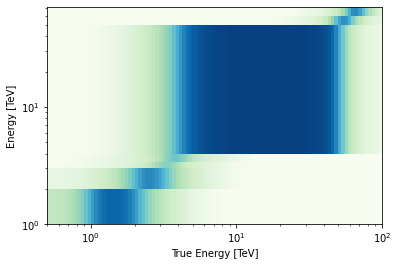

In [7]:
event_kernels.plot_matrix()

In [8]:
event_kernels.pdf_matrix.shape, e_energy.shape

((99, 7), (8,))

Text(0, 0.5, 'PDF Matrix Entry')

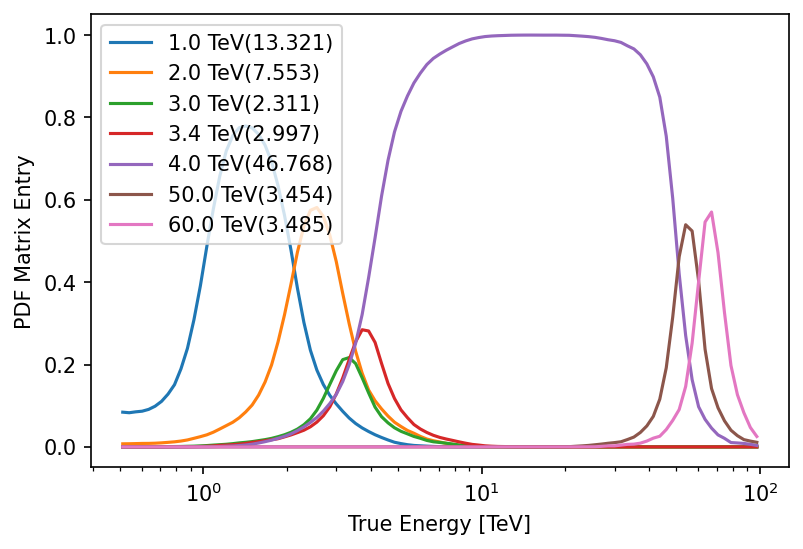

In [9]:
# not a usefull kernel as the bin sizes in reco energies are very different
plt.figure(dpi=150)
for i,e in enumerate(e_energy[:-1]):
    ker=event_kernels.pdf_matrix[:,i]
    plt.semilogx(event_kernels.axes[0].center, ker, label=f"{e}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("PDF Matrix Entry")

In [10]:
new_geom = geom.downsample(25).to_image().to_cube([migra_axis, energy_axis_true])

edisp_map = make_edisp_map(obs1.edisp, obs_pos, new_geom)

In [11]:
edisp_map.edisp_map.geom

WcsGeom

	axes       : ['lon', 'lat', 'migra', 'energy_true']
	shape      : (7, 7, 160, 99)
	ndim       : 4
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 21.5 deg
	width      : 3.5 deg x 3.5 deg
	wcs ref    : 83.6 deg, 21.5 deg

In [12]:
energy_axis_true = edisp_map.edisp_map.geom.axes["energy_true"]

geom_image = edisp_map.edisp_map.geom.to_image()
geom = geom_image.to_cube([energy_axis, energy_axis_true])

coords = geom.get_coord(sparse=True, mode="edges", axis_name="energy")

migra = coords["energy"] / coords["energy_true"]

coords = {
    "skycoord": coords.skycoord,
    "energy_true": coords["energy_true"],
    "migra": migra,
}
# this evaluates (interpolates) the integral (cumsum) at the migra coordinates
values = edisp_map.edisp_map.integral(axis_name="migra", coords=coords)

axis = edisp_map.edisp_map.geom.axes.index_data("migra")
data = np.clip(np.diff(values, axis=axis), 0, np.inf)

edisp_kernel_map = Map.from_geom(geom=geom, data=data.to_value(""), unit="")

Text(0, 0.5, 'integral over migra')

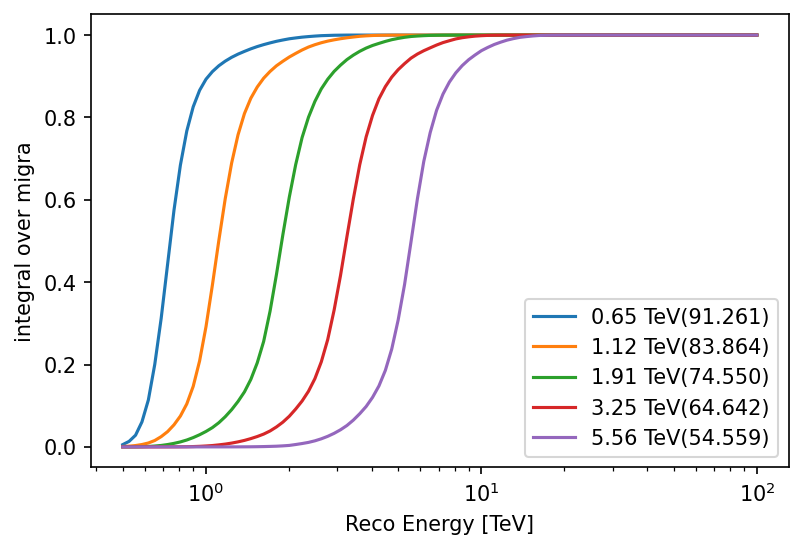

In [13]:
# plot the interpolated integrals
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=values[i,:,3,3]
    plt.semilogx(energy_axis.edges, ker, label=f"{energy_axis_true.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("Reco Energy [TeV]")
plt.ylabel("integral over migra")    

Text(0, 0.5, 'integral over migra')

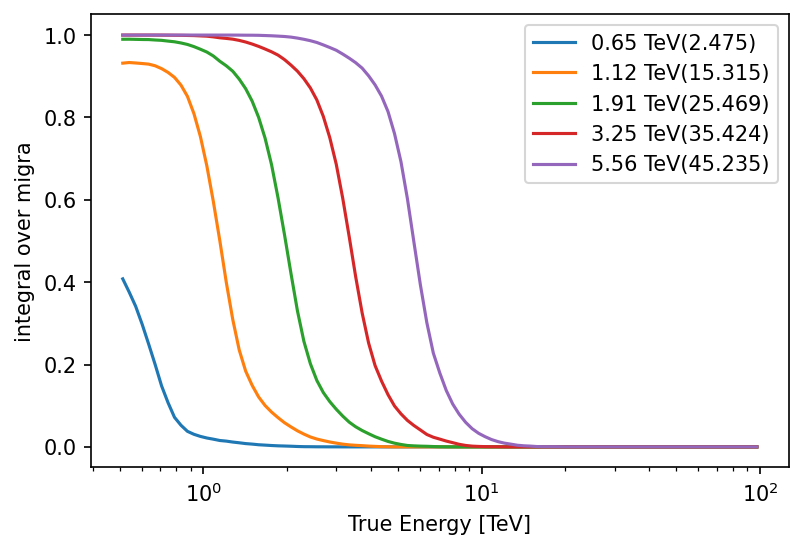

In [14]:
# if we look at it as function of Etrue we see something like 1 - integral
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=values[:,i,3,3]
    plt.semilogx(energy_axis_true.center, ker, label=f"{energy_axis.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("integral over migra")    

Text(0, 0.5, 'integral over migra')

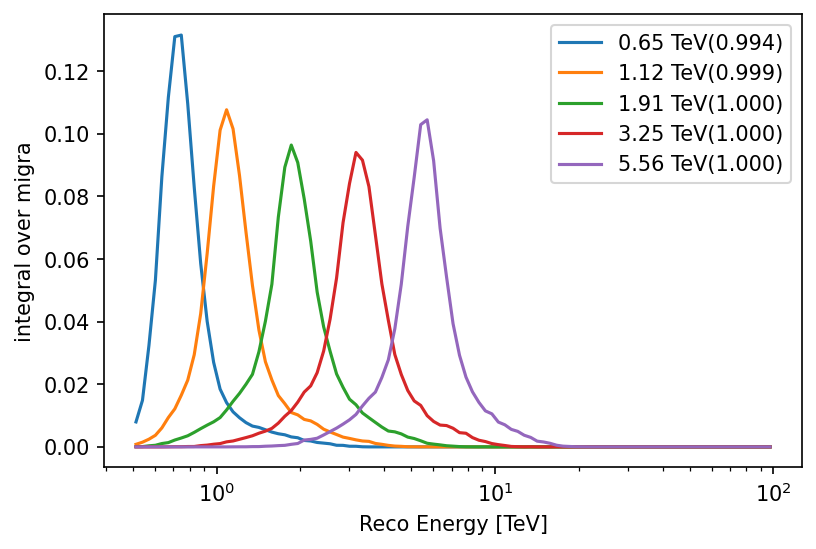

In [15]:
# plotting the difference of the integrals, nicely summs to 1
# this shows how much each true energy bin (each line) contributes to each reco energy bin
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=data[i,:,3,3]
    plt.semilogx(energy_axis.center, ker, label=f"{energy_axis_true.edges[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("Reco Energy [TeV]")
plt.ylabel("integral over migra") 

Text(0, 0.5, 'integral over migra')

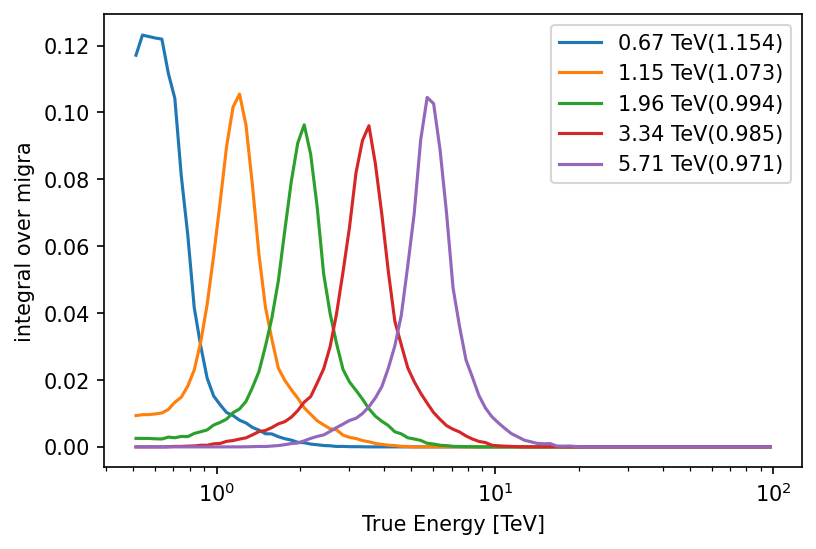

In [16]:
# similar as function of True energy. 
# this shows how much each reco energy bin (each line) gets from each true energy bin
plt.figure(dpi=150)
for i in [5,15,25,35,45]:
    ker=data[:,i,3,3]
    plt.semilogx(energy_axis_true.center, ker, label=f"{energy_axis.center[i]:.2f}({ker.sum():.3f})")
    
plt.legend()
plt.xlabel("True Energy [TeV]")
plt.ylabel("integral over migra")  

In [17]:
data.shape

(99, 99, 7, 7)

In [18]:
values.shape

(99, 100, 7, 7)

<AxesSubplot:xlabel='True Energy [TeV]', ylabel='Energy [TeV]'>

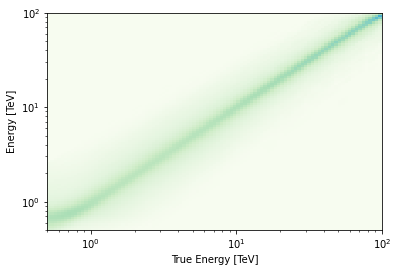

In [19]:
kernel_from_ds.plot_matrix()

In [20]:
kernel_from_ds.axes[1].center[16]

<Quantity 1.20913559 TeV>

Text(0.5, 0, 'energy_true [TeV]')

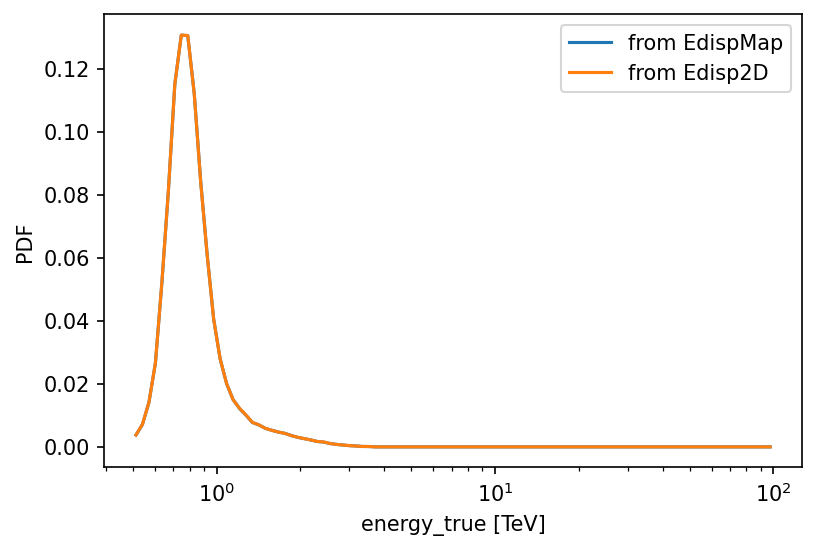

In [21]:
# this matches nicely if the bounds of the migra axis agree between MapDataset and Edisp2D. Otherwise the tail is cut.
plt.figure(dpi=150)
plt.plot(energy_axis.center, kernel_from_ds.pdf_matrix[7,:], label='from EdispMap')
plt.plot(energy_axis.center, kernel_from_edisp2d.pdf_matrix[7,:], label='from Edisp2D')
plt.legend()
plt.semilogx()
plt.ylabel('PDF')
plt.xlabel('energy_true [TeV]')

## Compute the Edisp factors 
needed for the direct unbineed method $E = E_\mathrm{true}$ and $E' = E_\mathrm{event}$

The `EnergyDispersion2D` contains the quantity $dP/d\mu = \frac{dP}{dE_\mathrm{reco}}E_\mathrm{true}$. We want $ \frac{dP}{dE_\mathrm{reco}}$, the probability for each true energy bin to reconstruct in $dE_\mathrm{reco}$. Then we can look at one $E_\mathrm{reco}$ and know the contribution from every true energy bin on which the model will be evaluated. Therefore we evaluate the Energy Dispersion at the given true energy edges and devide its quantity by the true energies. If we are sure that we only want the model offset we could also drop the other offsets. Then we evaluate at the events migration and cut on the given migration bounds to prevent extrapolation artifacts. This $D(E,E')=\frac{dP(E_\mathrm{true})}{dE_\mathrm{reco}}\Big\rvert_{E'}$  can be used to calculate the reco differential npred $\frac{\mathrm{npred}}{dE_\mathrm{reco}} = \int \phi(E) A_\mathrm{eff}(E) D(E,E') dE$. If we want to compare to the npred calculated with the binned `MapDataset` we need to multiply with the bin size $\Delta E_\mathrm{reco}|_{E'}$ which is proportional to the event's energy $E'$ and inverse proportional to the number of bins. Dependent on which quantity we want for the unbinned likelihood we can or cannot multiply our $D$ factors by the event energies.

- Instead of one fixed true energy axis for all events we could also use a matrix with a set true energy axis for each event. The model would need to be evaluated on that same true energy matrix. Then we could set the true energy range for each event according to its reco energy and the migration range. We would have better resolution without more memory and we would not need the cut on the migration bounds. However the model evaluation takes longer and also the combination with the PSF might be more difficult, especially if we also want to have an individual cutout in FoV for each event. For details see Giacomos example

In [22]:
def make_edisp_factors(edisp2d, events, energy_axis_true, pointing, model_pos):
    # use event offsets for larger models + good psf, true offset is closer to event offset
    offsets = events.radec.separation(pointing)[:,None] 
    # use model offset for small models or bad psf, true offset is closer to model offset
    offset = model_pos.separation(pointing)
    
    event_migra = events.energy[:,None]/energy_axis_true.center
    
    # interpolate the edisp to the true energy axis, possibly even model offset
    mm,ee,oo = np.meshgrid(edisp2d.axes['migra'].center,
                           energy_axis_true.center,
                           edisp2d.axes['offset'].center)
    dmigra = edisp2d.axes['migra'].bin_width[:,None]
    data = edisp2d.evaluate(offset=oo, energy_true=ee, migra=mm, method='linear') 
    edisp = EnergyDispersion2D(axes=[energy_axis_true,edisp2d.axes['migra'],edisp2d.axes['offset']],
                               data=data, interp_kwargs = edisp2d.interp_kwargs)
    edisp.normalize() # not sure if we want to normalize here
#     edisp.data *= dmigra.value # multiply with dmigra to get P
    edisp.data /= energy_axis_true.center.value[:,None,None]
    values = edisp.evaluate(offset=offset,energy_true=energy_axis_true.center, migra=event_migra, method='linear')
    # cut by migra axis edges since we don't want extrapolation
    m_min, m_max = edisp2d.axes['migra'].edges[[0,-1]]
    mask = (event_migra < m_max) & (event_migra > m_min)
    return values*mask

def make_exposure_factors(aeff, pointing, model_pos, livetime, energy_axis_true):
    offset = pointing.separation(model_pos)
    return aeff.evaluate(offset=offset, energy_true=energy_axis_true.center) * livetime

In [23]:
model_gauss = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="184.557 deg", lat_0="-5.784 deg", sigma='0.016 deg', frame = 'galactic'),
    spectral_model=LogParabolaSpectralModel(amplitude='3.5e-11 cm-2 s-1 TeV-1', 
                                          reference='1 TeV', 
                                          alpha=1.8, 
                                          beta=0.4
                                         ),
    name='crab_model_gauss'
    )

model_gauss.spectral_model.amplitude.value /= 10. # 10 times weaker signal than the Crab

dataset.models=[model_gauss]

In [24]:
edisp2d= obs1.edisp
events = obs1.events.select_energy([0.7,50]*u.TeV)
events = events.select_offset([0.5,1]*u.deg)
offsets = events.radec.separation(obs_pos)[:,None] 
offset = obs_pos.separation(model_gauss.position)
event_e = events.energy

# compare to my inverse Edisp
edispI = EdispInv(edisp2d, event_e.min(), event_e.max())
edisp_factors = edispI.evaluate(offset = offset, energy=event_e[:,None], 
                                energy_true=energy_axis_true.center[None,:], method='linear')
edisp_factors.shape
# compare to the gammay EdispKernel (transposed)
ek = edisp2d.to_edisp_kernel(offset=offset, energy_true=energy_axis_true.edges, energy=energy_axis.edges)

In [25]:
D=make_edisp_factors(obs1.edisp,events, energy_axis_true, obs1.pointing_radec, model_gauss.position)
exp_fac = make_exposure_factors(obs1.aeff, obs_pos, 
                                model_gauss.position, 
                                obs1.fixed_pointing_info.duration, energy_axis_true)
# test.normalize()

In [42]:
# some timing test
%timeit make_edisp_factors(obs1.edisp,events, energy_axis_true, obs1.pointing_radec, model_gauss.position)
print(f'for {len(events.table)} events')

59.8 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
for 836 events


15.419304929480754 1.029041409225921 1.639155485992184
4.8194632917724824 1.0050361003470867 1.7893850163935896
3.7536773706337168 1.0045270906167034 1.796288250606465


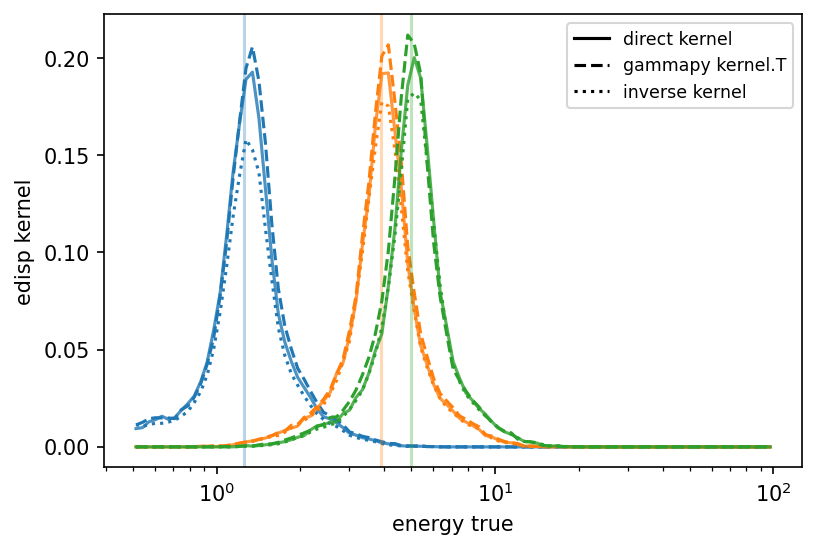

In [27]:
# the shapes of the Kernels agree nicely, only the scaling is different. 
# In the end we don't care about the scaling since it will be a constant in the log likelihood
plt.figure(dpi=150)
for i in [50,52,54]:
    l=plt.semilogx(energy_axis_true.center, D[i,:]*event_e[i]/10, alpha=0.8)
    c=l[0].get_color()
    plt.axvline(events.energy[i].value, c=c, alpha=0.3)
    
    idx=np.argmin(np.abs(events.energy[i]-energy_axis_true.center))
    plt.plot(energy_axis_true.center,ek.pdf_matrix[:,idx]*2, color=c, ls='--')
    plt.plot(energy_axis_true.center,edisp_factors[i,:], color=c, ls=':')
    print(D[i,:].sum(), ek.pdf_matrix[:,idx].sum(), edisp_factors[i,:].sum())

plt.xlabel('energy true')
plt.ylabel("edisp kernel")
# plt.ylim(0,1)

plt.plot([],[],c='k', label='direct kernel')
plt.plot([],[],c='k', ls='--', label='gammapy kernel.T')
plt.plot([],[],c='k', ls=':', label='inverse kernel')
plt.legend(fontsize='small')

## now compare the response and interpolated npred
In the end our method needs to be able to predict the number of expected events in an Interval $dE_\mathrm{reco}$. So we compute the npred spectrum using the established binned method and interpolate it at the events energies. This result can than be compared to our "response"

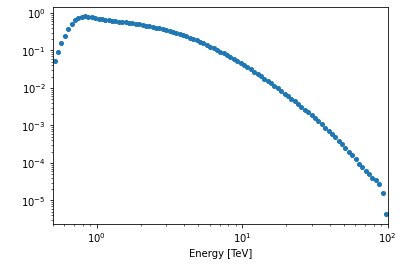

In [28]:
ds_spec=dataset.npred().get_spectrum()
ds_spec.plot()
response_ds = ds_spec.interp_by_coord(coords= events.map_coord(ds_spec.geom))

In [29]:
npred=model_gauss.integrate_geom(dataset.exposure.geom).get_spectrum()
response = (npred.data.flatten()*D*exp_fac.to_value(1/npred.unit)).sum(axis=1)

In [30]:
# interpolate the bin width at the event's energies
bin_width_map = ds_spec.copy()
bin_width_map.data = energy_axis_true.bin_width.value
bin_width = bin_width_map.interp_by_coord(coords= events.map_coord(ds_spec.geom))

Text(0, 0.5, 'npred')

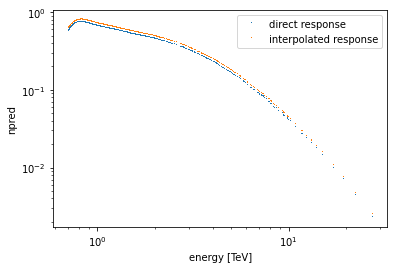

In [31]:
# compare using the event energy and number of bins
plt.loglog(events.energy, response*events.energy/energy_axis_true.nbin_per_decade*2 , ls="None", marker=',', label='direct response')
plt.loglog(events.energy, response_ds, ls="None", marker=',', label='interpolated response')
# The additional factor is not a problem since the likelihoods will not be sensitive to constants
plt.legend()
plt.xlabel("energy [TeV]")
plt.ylabel("npred")

Text(0, 0.5, 'npred')

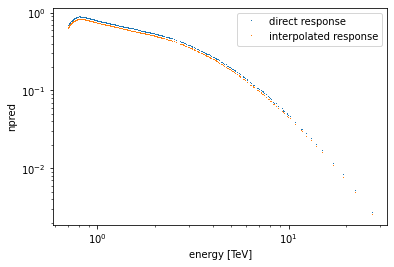

In [32]:
# now compare using the bin width of the dataset
plt.loglog(events.energy, response*bin_width, ls="None", marker=',', label='direct response')
plt.loglog(events.energy, response_ds, ls="None", marker=',', label='interpolated response')

plt.legend()
plt.xlabel("energy [TeV]")
plt.ylabel("npred")

Text(0, 0.5, 'interpolated response')

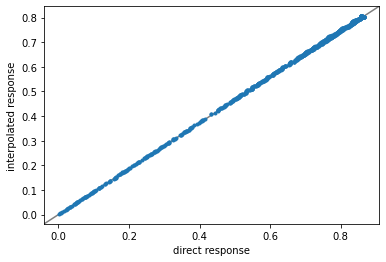

In [33]:
# We get a very nice correlation for our method and the binned method
plt.plot(response*bin_width, response_ds, ".")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response")

Text(0, 0.5, 'interpolated response / direct response')

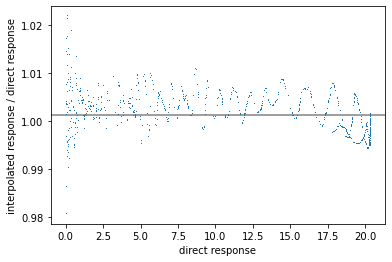

In [34]:
# the relative differences are mostly within 1%.
# We believe that our method is more precise as it makes full use of the information in the Energy Dispersion.
# for rougher binning the differences get larger
plt.plot(response, response_ds/response/events.energy*energy_axis_true.nbin_per_decade/2.15, ",")
plt.plot([0,1],[.5,.5], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response / direct response")

Text(0, 0.5, 'interpolated response / direct response')

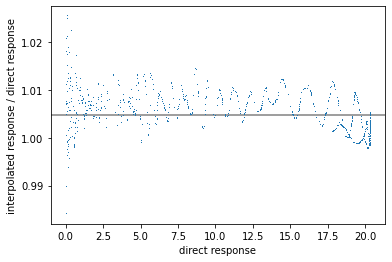

In [35]:
# similar picture when comparing with the bin width
plt.plot(response, response_ds/response/bin_width/0.93, ",")
plt.plot([0,1],[.5,.5], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response / direct response")

### check if the exposure makes the difference

In [36]:
npred2=model_gauss.integrate_geom(dataset.evaluators['crab_model_gauss'].exposure.geom).get_spectrum()
response2 = (npred2.data*dataset.evaluators['crab_model_gauss'].exposure.quantity.to_value(1/npred.unit)).sum(axis=(1,2))
response2=(D*response2).sum(axis=1)

Text(0, 0.5, 'direct response (our exposure)')

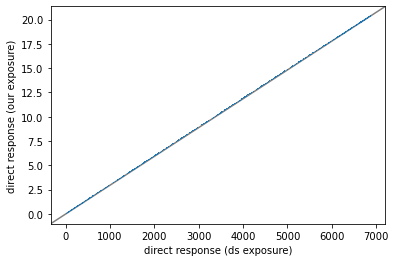

In [37]:
# the result is only shifted by a factor
plt.plot(response2, response, ",")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response (ds exposure)")
plt.ylabel("direct response (our exposure)")

### check if the inverse Edisp performs different
--> the previously used inverse Edisp performs worse

In [38]:
response_inv = (npred.data.flatten()*edisp_factors*exp_fac.to_value(1/npred.unit)).sum(axis=1)

Text(0, 0.5, 'direct response (inv Edisp)')

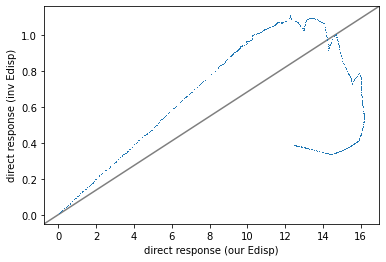

In [39]:
plt.plot(response*events.energy, response_inv, ",")
plt.plot([0,1],[0,1], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response (our Edisp)")
plt.ylabel("direct response (inv Edisp)")

Text(0, 0.5, 'npred')

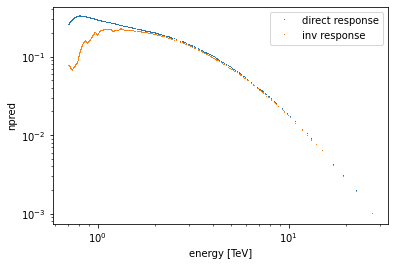

In [40]:
plt.loglog(events.energy, response*events.energy/5e1, ls="None", marker=',', label='direct response')
plt.loglog(events.energy, response_inv/5, ls="None", marker=',', label='inv response')
# Also here the factor of 5 comes from different Ereco bin sizes which is expected and 
# not a problem since the likelihoods will not be sensitive to constants
plt.legend()
plt.xlabel("energy [TeV]")
plt.ylabel("npred")

Text(0, 0.5, 'interpolated response / direct response')

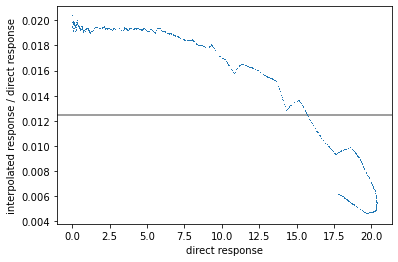

In [41]:
plt.plot(response, response_inv/response/events.energy/5, ",")
plt.plot([0,1],[.5,.5], c='k', transform=plt.gca().transAxes, zorder=0, alpha=0.5)
plt.xlabel("direct response")
plt.ylabel("interpolated response / direct response")